In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
from copy import deepcopy as dc
import random
import geometry_bspline as bsp_geom
import NeuralImplicit as NI
torch.set_default_dtype(torch.float64)

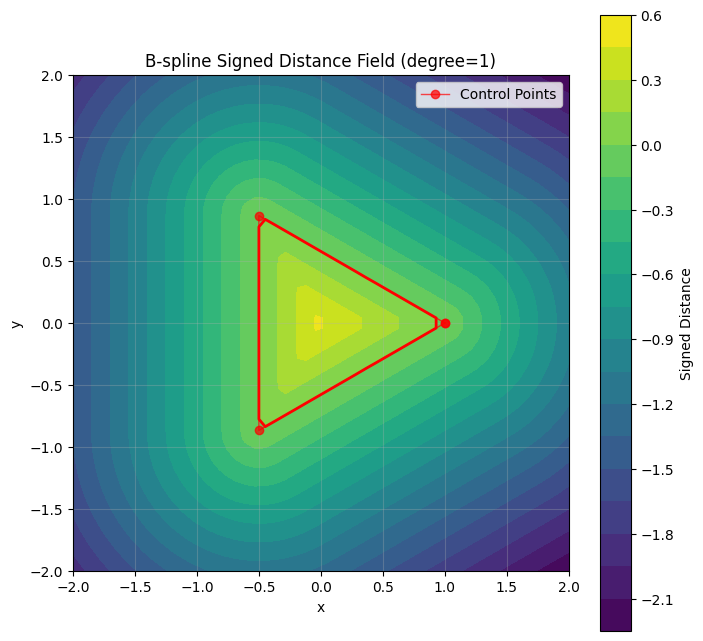

In [3]:
ctrl_pts = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
ctrl_pts = bsp_geom.create_polygon_bspline_control_points(num_vertices=3, degree=1)
bsp_geom.plot_bspline_distance_field(ctrl_pts, degree=1, N=50)

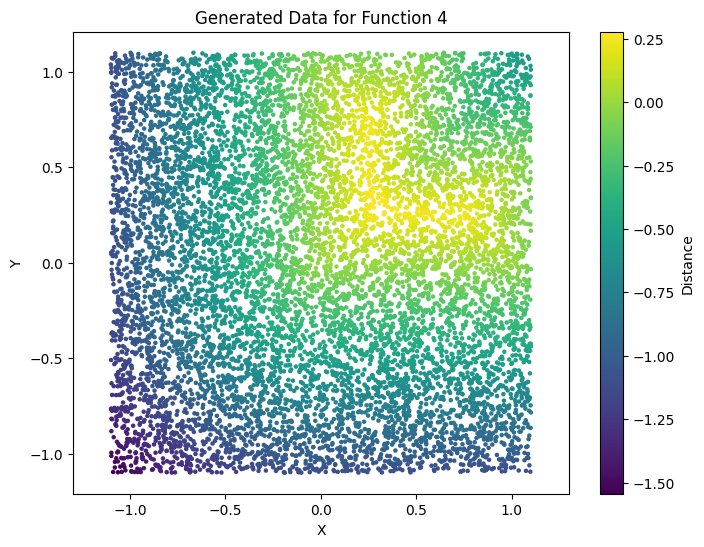

In [2]:
def plot_generated_data(fun_num, num_samples=5000, data_gen_params={}):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    coordinates, distances = NI.generate_bspline_data(num_samples,fun_num, device=device, data_gen_params=data_gen_params)
    coordinates = coordinates.cpu().numpy()
    distances = distances.cpu().numpy()

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=distances[:, 0], cmap='viridis', s=5)
    plt.colorbar(sc, label='Distance')
    plt.title(f'Generated Data for Function {fun_num}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()
plot_generated_data(fun_num=4, num_samples=10000, data_gen_params={"num_vertices":3})

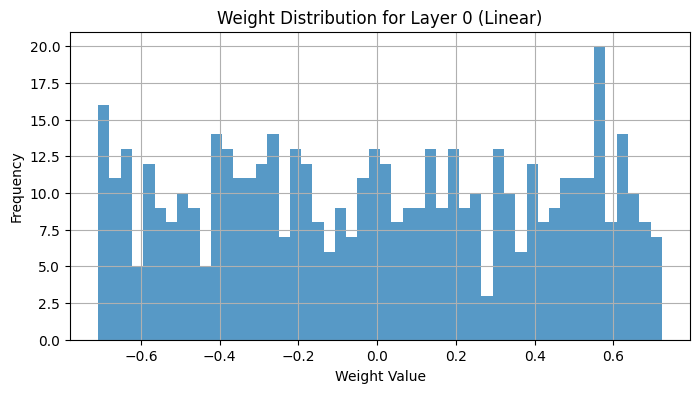

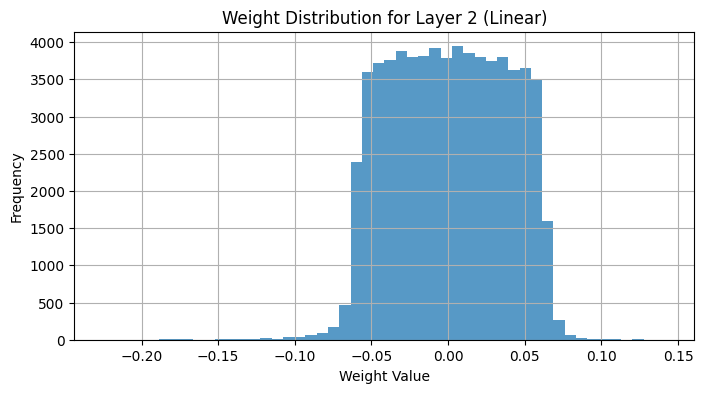

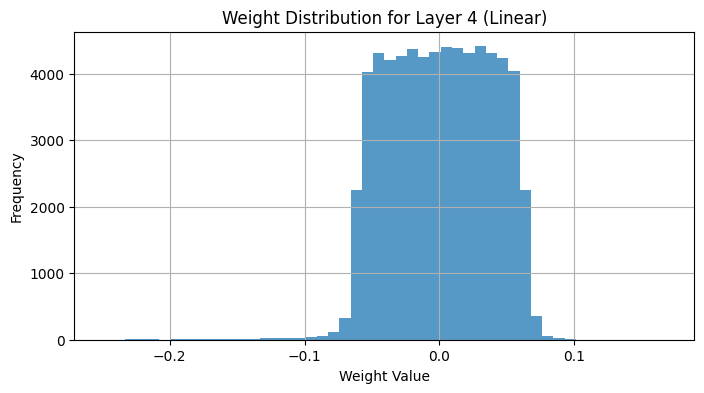

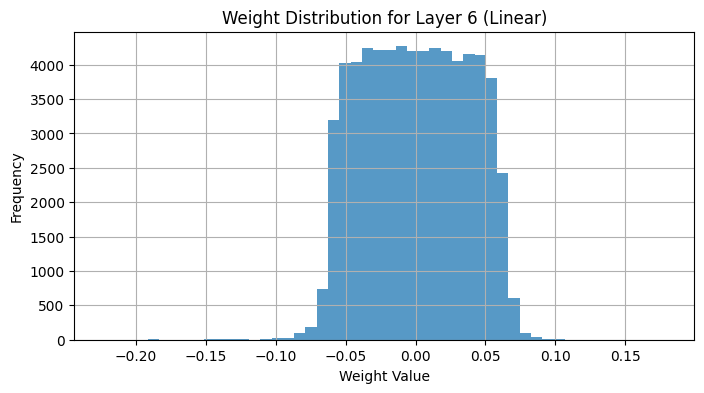

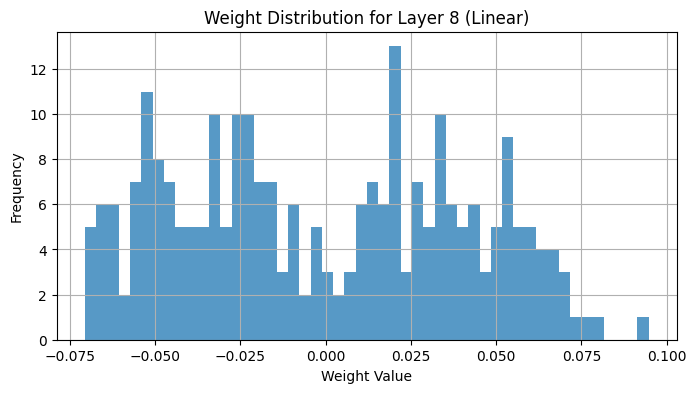

In [48]:
NI.plot_model_weight_per_layer_hyst(model)

In [ ]:
def train_model(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
    knots = bsp_geom.create_knot_vector(len(star_cp), degree=1)
    L_EIKON = 1e3
    L_BND = 1e4
    L_BND_GRAD = 1e1
    L_XI = 3e2
    NUM_POINTS = 1000
    for epoch in range(num_epochs):
        star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
        boundary_pts, t_values = bsp_geom.generate_points_on_curve(star_cp, num_points=NUM_POINTS, degree=1, device=None, return_t=True)
        other_pts = torch.randn((NUM_POINTS,2))*2-1
        other_pts = other_pts.clone().detach().requires_grad_(True)
        pred_other = model(other_pts)
        grds = torch.autograd.grad(outputs=pred_other, inputs=other_pts, grad_outputs=torch.ones_like(pred_other),retain_graph=True, allow_unused=True, create_graph=True)
        eikonloss = torch.sum(grds[0]**2,dim=1)
        eikonloss_output = torch.abs(1-torch.sqrt(eikonloss)).mean()
        boundary_pts = boundary_pts.clone().detach().requires_grad_(True)
        bond_normal = bsp_geom.bspline_normalvectors(t_values,star_cp,knots,degree=1)
        # elementwise scalar product of bond_normal and gradient of pred_boundary
        pred_boundary = model(boundary_pts)
        grds_boundary = torch.autograd.grad(outputs=pred_boundary, inputs=boundary_pts, grad_outputs=torch.ones_like(pred_boundary),retain_graph=True, allow_unused=True, create_graph=True)
        #print(grds_boundary)
        scalar_prods = torch.sum(grds_boundary[0] * bond_normal, dim=1)
        scalar_loss = torch.abs(1- scalar_prods).mean()
        loss_boundary = torch.abs(torch.mean(torch.abs(pred_boundary)))
        loss_xi = torch.mean(torch.exp(-100*torch.abs(pred_other)))
        loss = L_BND*loss_boundary + L_EIKON*eikonloss_output + L_XI*loss_xi + L_BND_GRAD*scalar_loss
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            CALCULATE_ERROR = False
            if CALCULATE_ERROR:
                pts = torch.randn((5000,2))*2-1
                with torch.no_grad():
                    pred = model(pts)
                    star_sdf = bsp_geom.bspline_signed_distance_vectorized(pts,star_cp,degree=1)
                    error = criterion(pred.squeeze(), star_sdf)
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}, SDF Error: {error.item():.6f}")
                print(f"Losses: Boundary: {L_BND*loss_boundary.item():.6f}, Eikonal: {L_EIKON*eikonloss_output.item():.6f}, Xi: {L_XI*loss_xi.item():.6f}, Scalar prod: {L_BND_GRAD*scalar_loss.item():.6f}")
            else:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            
train_model(model,100)

In [45]:

architecture = [2,256,256,256,1]
#model = NI.Siren(architecture, outermost_linear=True, first_omega_0=60, hidden_omega_0=60)
#model = NI.PE_Relu(architecture=[2,256,256,256,256,1], num_freqs=5)
model = NI.NeuralNetwork(architecture=[2,256,256,256,256,1])
print(f"number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

model.optimizer = torch.optim.Adam(lr=1e-5, params=model.parameters())


#model.lr_scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=1000, gamma=0.8)

model.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max=50000, eta_min=1e-6)

# SIREN 198k parameters - Adam - 1e-6 
# ReLU 189k parameters - Adam - 1e-6

number of parameters: 198401


In [46]:

NI.train_models_with_extras([model],num_epochs = 30000, batch_size = 1000, fun_num=3, eikon_coeff=0.0, boundry_coeff=0,
                            data_gen_mode='bspline', use_scheduler = True,
                            crt = nn.L1Loss(),create_error_distribution_hystory=True,error_distribution_resolution=100, 
                            create_SDF_history=True, hytory_after_epochs=200)


Epoch [0], Losses: ReLU: 0.24741341845257145
Epoch [2999], Losses: ReLU: 0.0034147647197410795
Epoch [5999], Losses: ReLU: 0.001683508609318378
Epoch [8999], Losses: ReLU: 0.0013386264849947168
Epoch [11999], Losses: ReLU: 0.001086600886707184
Epoch [14999], Losses: ReLU: 0.0009156825031333308
Epoch [17999], Losses: ReLU: 0.0008459816169330789
Epoch [20999], Losses: ReLU: 0.0007921738470558213
Epoch [23999], Losses: ReLU: 0.0007662688121213994
Epoch [26999], Losses: ReLU: 0.0006430773178330604
Epoch [29999], Losses: ReLU: 0.0005810763308697931


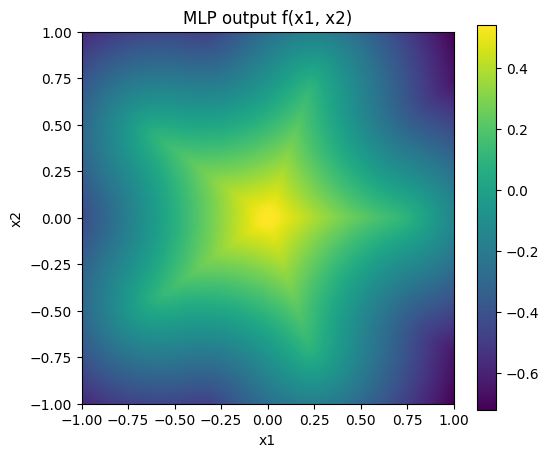

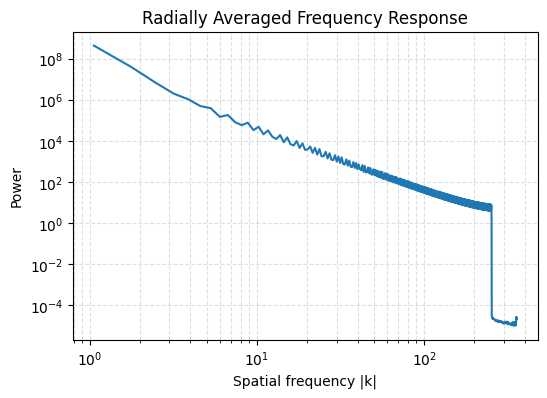

In [47]:
N = 1014                         # grid resolution
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)

pts = np.stack([X.ravel(), Y.ravel()], axis=1)
pts_t = torch.tensor(pts, dtype=torch.float64)

with torch.no_grad():
    Z = model(pts_t).cpu().numpy().reshape(N, N)
    #rounded_star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
    #L_shape = bsp_geom.create_L_shape_bspline_control_points(1)
    #Z = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=2).numpy().reshape(N, N)
# ------------------------------------------------------------
# 3. Plot the output f(x)
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.imshow(Z, extent=[-1,1,-1,1], origin='lower')
plt.title("MLP output f(x1, x2)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()

# ------------------------------------------------------------
# 4. Compute 2D FFT (frequency response)
# ------------------------------------------------------------
F = np.fft.fftshift(np.fft.fft2(Z))
power = np.abs(F)**2

# Frequency axes
freq_x = np.fft.fftshift(np.fft.fftfreq(N, d=(x_vals[1]-x_vals[0])))
freq_y = np.fft.fftshift(np.fft.fftfreq(N, d=(y_vals[1]-y_vals[0])))

FX, FY = np.meshgrid(freq_x, freq_y)
radial_freq = np.sqrt(FX**2 + FY**2).ravel()

# ------------------------------------------------------------
# 5. Radially averaged power spectrum
# ------------------------------------------------------------
nbins = N // 2
bins = np.linspace(0, radial_freq.max(), nbins+1)
radial_power = np.zeros(nbins)
counts = np.zeros(nbins)

bin_index = np.digitize(radial_freq, bins) - 1
flat_power = power.ravel()

for i, p in enumerate(flat_power):
    k = bin_index[i]
    if 0 <= k < nbins:
        radial_power[k] += p
        counts[k] += 1

radial_power /= np.maximum(1, counts)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# 6. Plot frequency response
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.loglog(bin_centers[1:], radial_power[1:])
plt.title("Radially Averaged Frequency Response")
plt.xlabel("Spatial frequency |k|")
plt.ylabel("Power")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()

In [6]:
#torch.set_default_dtype(torch.float64)
next(model.parameters()).dtype
#print(torch.get_default_dtype())

torch.float64

In [6]:
torch.set_default_dtype(torch.float64)

MovieWriter imagemagick unavailable; using Pillow instead.


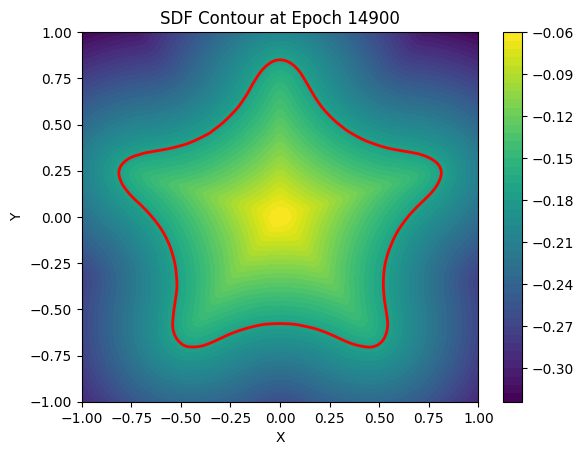

In [49]:
NI.create_animation_SDF_contourf(model, interval=500, save_path="SDF_evolution_ReLU_cos.gif", skip_initial_frames=0, adaptive_scaling=False, plot_cntr = True)

In [53]:
!ffmpeg -i error_anim_normal_sched_cos.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" error_anim_normal_sched_cos.mp4


ffmpeg version 8.0.1-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-liboapv --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --

MovieWriter imagemagick unavailable; using Pillow instead.


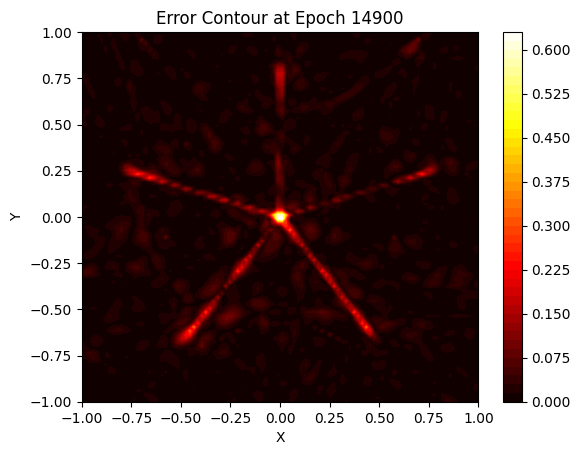

In [51]:
NI.create_animation_error_contourf(model, interval= 500,save_path="error_anim_ReLU_cos.gif",skip_initial_frames=0, adaptive_scaling=True, plot_cntr = False)

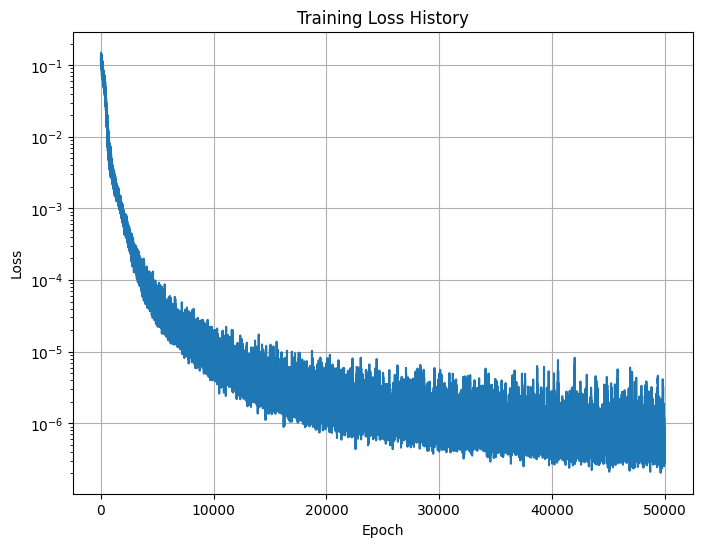

In [17]:
#plot loss history
plt.figure(figsize=(8, 6))
plt.plot(model.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.yscale('log')
plt.show()

In [4]:
def plot_last_error_contourf(model, resolution=200, adaptive_scaling=True, plot_cntr=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = torch.linspace(-1, 1, resolution, device=device)
    y = torch.linspace(-1, 1, resolution, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    coords = torch.stack([X.flatten(), Y.flatten()], dim=-1)    
    error = model.error_distribution_history[-1]
    Z = error.reshape(resolution, resolution).cpu().numpy()
    plt.figure(figsize=(8, 6))
    if adaptive_scaling:
        vmin = np.percentile(Z, 5)
        vmax = np.percentile(Z, 95)
        im = plt.imshow(Z, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    else:
        im = plt.imshow(Z, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
    plt.colorbar(im, label='Error')
    if plot_cntr:
        plt.contour(X.cpu().numpy(), Y.cpu().numpy(), Z, levels=[0], colors='red', linewidths=0.5)
    plt.title('Error Distribution Contour Plot')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
plot_last_error_contourf(model, resolution=200, adaptive_scaling=True, plot_cntr=True)

ValueError: cannot reshape array of size 10000 into shape (200,200)

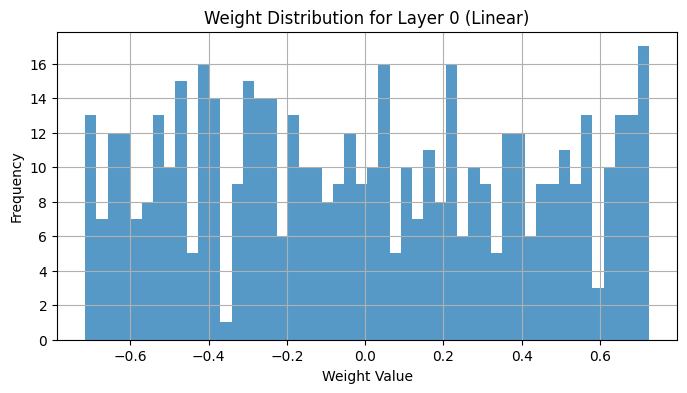

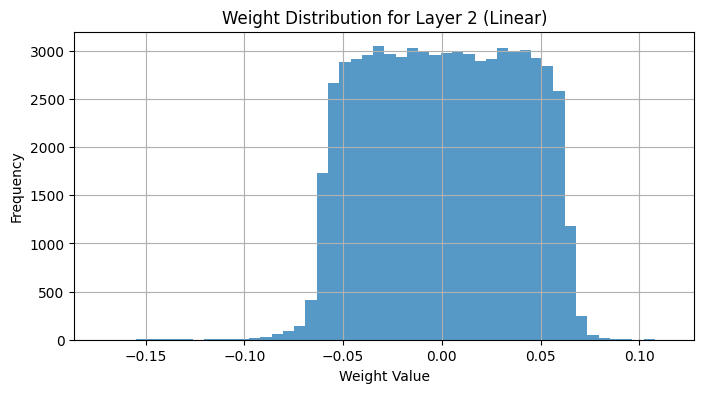

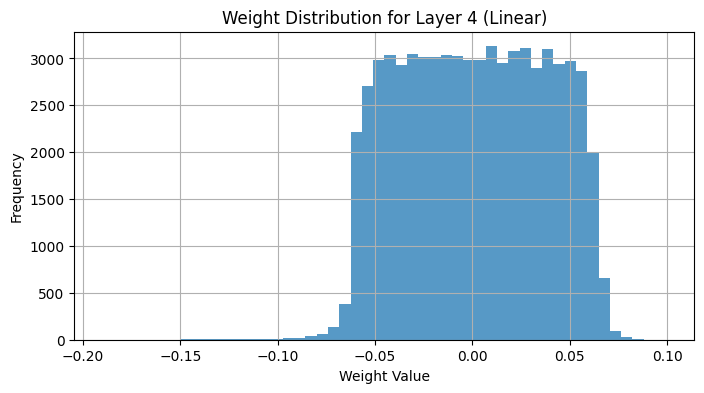

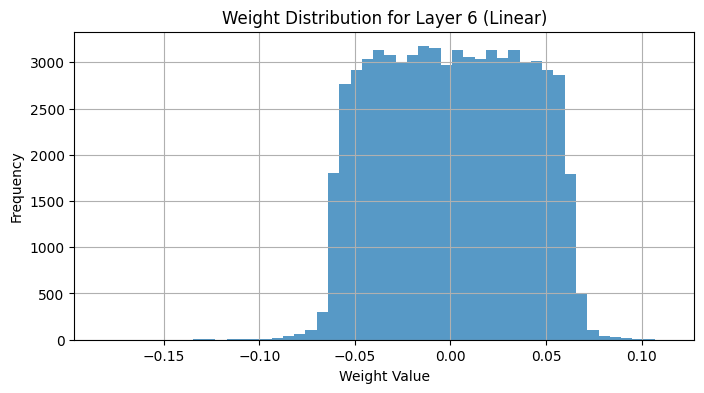

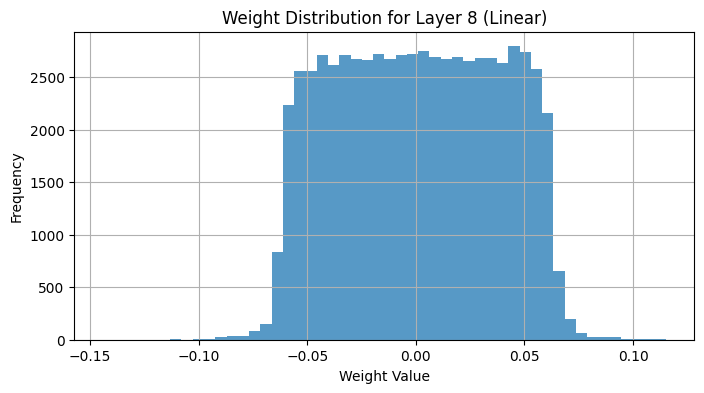

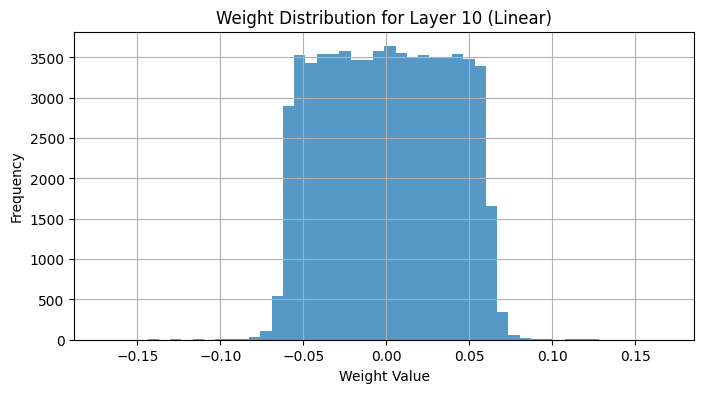

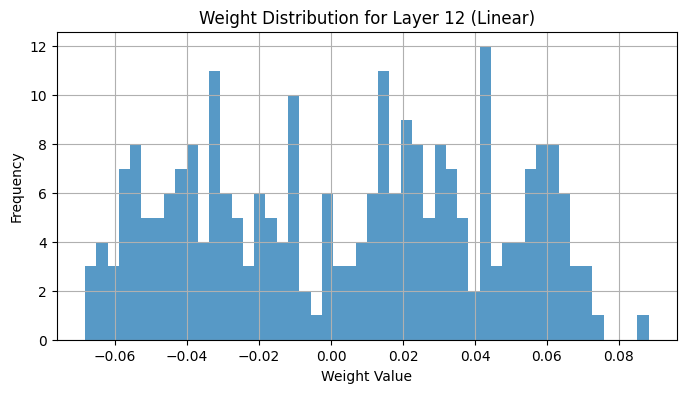

In [21]:
NI.plot_model_weight_per_layer_hyst(model)

In [8]:
def train_model_old(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    cntrl_pts = bsp_geom.create_polygon_bspline_control_points(5,degree=1)
    knots = bsp_geom.create_knot_vector(len(cntrl_pts), degree=1)
    for epoch in range(num_epochs):
        pts = torch.randn((500,2))*2-1
        #pts = pts.clone().detach().requires_grad_(True)
        pred = model(pts)
        target = bsp_geom.bspline_signed_distance_vectorized(pts,cntrl_pts,degree=1)
        loss_sdf = criterion(pred.squeeze(), target)
        loss = loss_sdf
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        #model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
train_model_old(model,100)

Epoch 0, Loss: 4.556866
Epoch 10, Loss: 3.761360
Epoch 20, Loss: 3.181367
Epoch 30, Loss: 2.467447
Epoch 40, Loss: 2.155694
Epoch 50, Loss: 2.265133
Epoch 60, Loss: 1.921426
Epoch 70, Loss: 1.436932
Epoch 80, Loss: 1.295657
Epoch 90, Loss: 1.372169


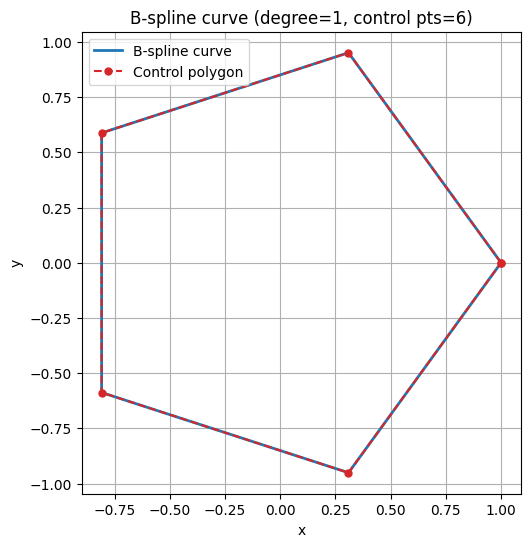

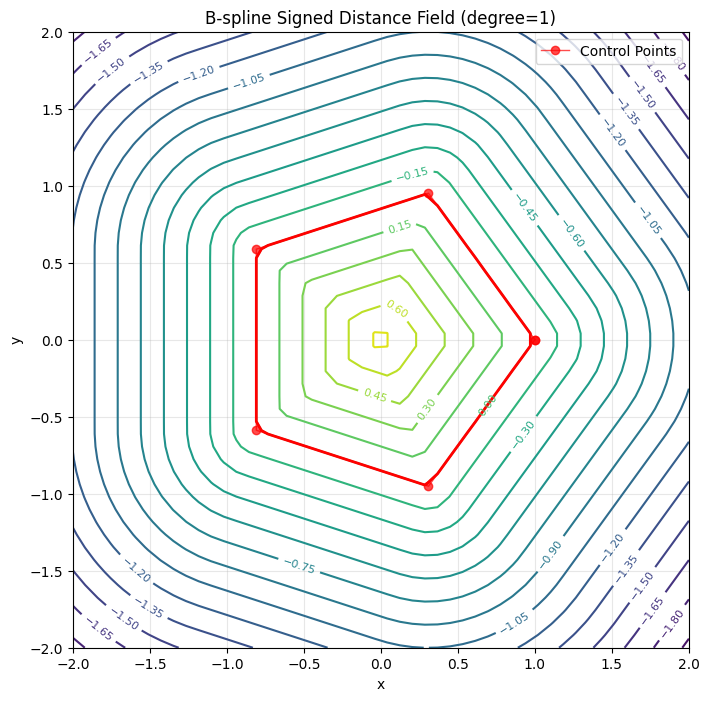

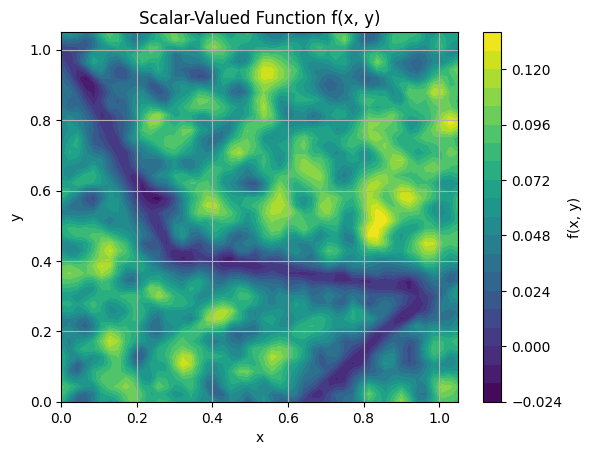

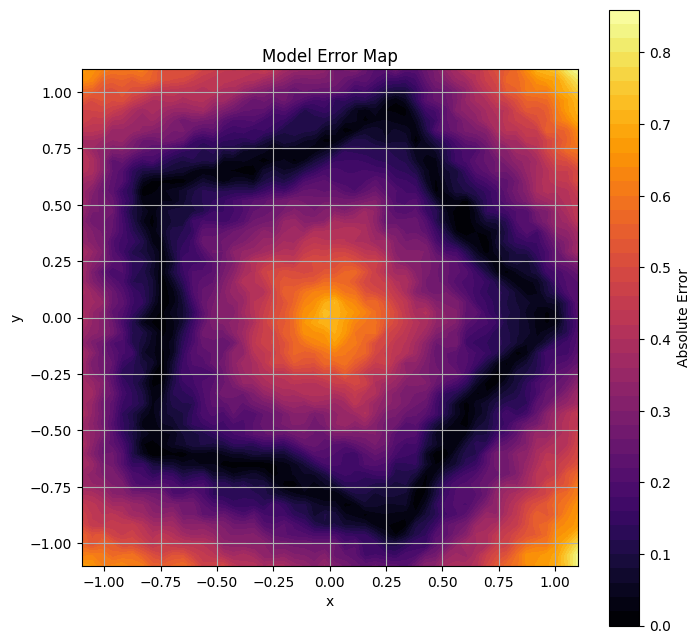

In [14]:
pentagon_cp = bsp_geom.create_polygon_bspline_control_points(5,degree=1)
bsp_geom.plot_bspline_curve(pentagon_cp, degree=1, show_control_points=True)
bsp_geom.plot_bspline_distance_field(pentagon_cp, degree=1, N=50,contour=True)
NI.plotDisctancefunction(model, N=50)
bsp_geom.plot_model_error_map(model, pentagon_cp, degree=1,N=50)

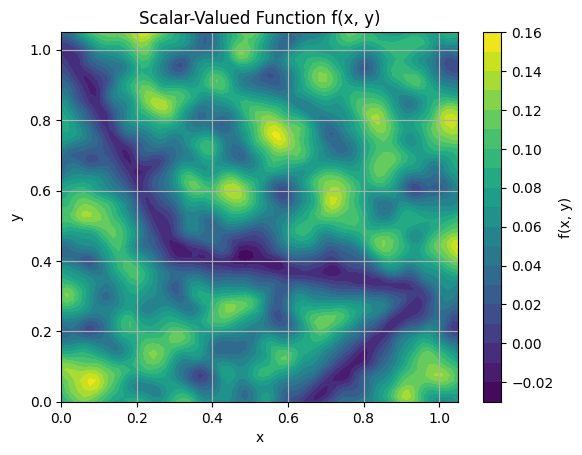

In [ ]:
import NeuralImplicit
NeuralImplicit.plotDisctancefunction(model,70,False)